In [6]:
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc, CirclePolygon
import json
from itertools import product
import generate_spot_values as gen
from Game import Game

In [3]:
%matplotlib notebook

In [4]:
matplotlib.get_backend()

'nbAgg'

In [7]:
game=Game('0021500495.json', 2)

<IPython.core.display.Javascript object>


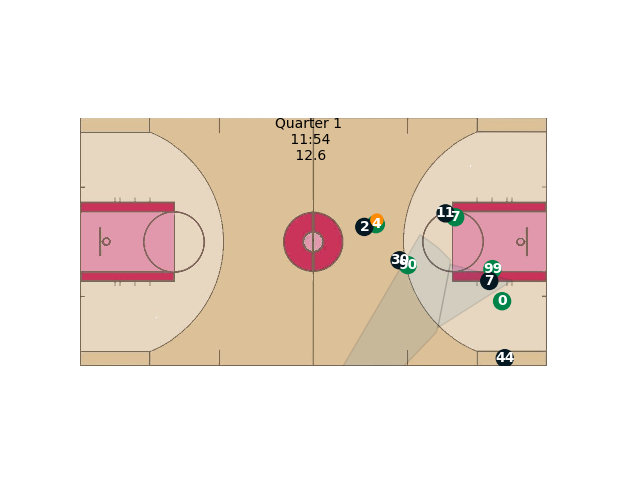

In [9]:
game.start()

In [109]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()
    hoop = Circle((4, 25), radius=.75, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((4, 22), -.5, 6, linewidth=lw, color=color)
    outer_box = Rectangle((0, 17), 18, 16, linewidth=lw, color=color,
                          fill=False)
    top_free_throw = CirclePolygon((19, 25), radius=5.5, linewidth=lw, color=color, fill=False)
    corner_three_a = Rectangle((0, 3), 14, 0, linewidth=lw,color=color)
    corner_three_b = Rectangle((0, 47), 14, 0, linewidth=lw,color=color)
    three_arc = Arc((4, 25), 47.5, 47.5, theta1=-68, theta2=68, linewidth=lw, color=color)
    court_elements = [hoop, backboard, outer_box, top_free_throw, corner_three_a, corner_three_b, three_arc]
    if outer_lines:
        outer_lines = Rectangle((0,0), 50, 50, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    for element in court_elements:
        ax.add_patch(element)
    return ax

In [110]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

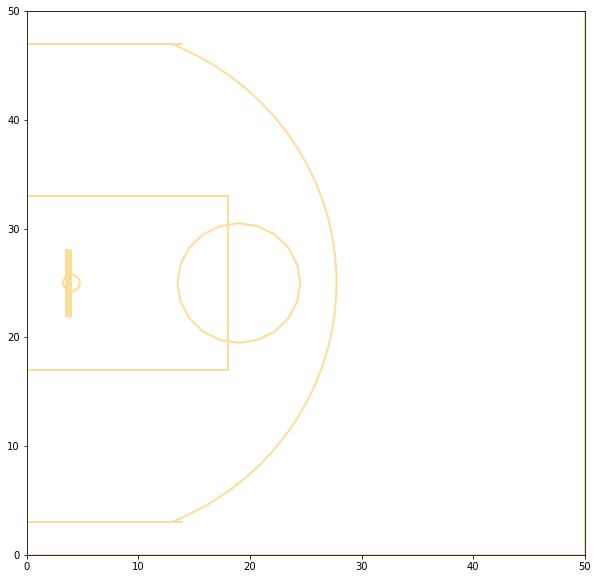

In [111]:
plt.figure()
draw_court(color='#ffdd99',outer_lines=True)
plt.xlim(0,50)
plt.ylim(0,50)
plt.show() 

In [112]:
with open('0021500495.json') as f:
    gm=json.load(f)

In [113]:
moments=gm['events'][5]['moments']

In [114]:
teams=[moments[0][5][1][0], moments[0][5][6][0]]

In [115]:
lst = []
for i in (range(len(moments))):
    all_in_same = True
    smaller_half = (moments[i][5][1][2] > 47)
    for j in range(1,11):
        if (moments[i][5][j][2] > 47) != smaller_half:
            all_in_same = False
            break
    if all_in_same:
        lst.append(i)

In [116]:
def get_player_positions(moment):
    x=[x[2] for x in moment[5][1:]]
    y=[x[3] for x in moment[5][1:]]
    return x, y

In [117]:
def get_frame(moment):
    frame={}
    frame[moment[5][1][0]]=[(x[2], x[3], x[1]) for x in moment[5][1:6]]
    frame[moment[5][6][0]]=[(x[2], x[3], x[1]) for x in moment[5][6:]]
    frame['ball']=[moment[5][0][2], moment[5][0][3]]
    return frame

In [154]:
frame_data=get_frame(moments[100])

In [155]:
frame_data

{1610612738: [(23.98504, 17.76193, 101161),
  (28.47838, 28.55661, 202738),
  (28.6877, 15.19659, 202340),
  (8.00598, 3.25564, 203109),
  (11.34649, 30.91707, 203096)],
 1610612751: [(8.46479, 16.07909, 2207),
  (18.51383, 33.02512, 101127),
  (9.21186, 30.44531, 201152),
  (13.85767, 26.53368, 201572),
  (21.11921, 23.16169, 202711)],
 'ball': [11.9951, 29.52836]}

In [156]:
players = [frame_data[team][j][2] for team,j in product(teams, range(5))]

In [157]:
def ds2points(frame_data, teams):
    points = np.zeros((10, 2))
    for i,team in enumerate(teams):
        for j in range(5):
            points[5*i+j,0] = frame_data[team][j][0]
            points[5*i+j,1] = frame_data[team][j][1]
    return points
points = ds2points(frame_data, teams)

In [158]:
weight_func = lambda x: 1.0 / (1.0 + x)

In [159]:
players = []
for team in teams:
    for i in range(5):
        players.append(frame_data[team][i][2])

def get_all_value(players, points, teams, frame_data):
    grid_centers, grid_vals = gen.get_midpoints_and_values()
    player_value_orig_lst = {}
    vor_points = ds2points(frame_data, teams)
    kdtree_orig = cKDTree(points)
    for player in players:
        player_value_orig_lst[player] = []

    for i in range(10):
        for j in range(10):
            center = grid_centers[i][j]
            test_point_dist, test_point_regions = kdtree_orig.query(np.array(center).reshape((1,2)), k=1)
            player = players[test_point_regions[0]]
            player_value_orig_lst[player].append((i,j,test_point_dist[0]))
    player_val_orig = {}
    for player in players:
        player_val_orig[player] = 0

    for player in players:
        for spot_i, spot_j, spot_dist in player_value_orig_lst[player]:
            player_val_orig[player] += weight_func(spot_dist) * grid_vals[spot_i][spot_j]
            
    return player_val_orig

In [160]:
player_val_orig = get_all_value(players, points, teams, frame_data)
player_val_orig

{2207: 60.30998836520699,
 101127: 66.22540712250391,
 101161: 40.114758515069056,
 201152: 54.26269113988754,
 201572: 36.01767749105896,
 202340: 79.53915917529508,
 202711: 31.99530065704159,
 202738: 87.27178645573962,
 203096: 20.69309265242798,
 203109: 74.46271345559596}

In [161]:
def get_player_team(player, teams, frame_data):
    for team in teams:
        for i in range(len(frame_data[team])):
            if frame_data[team][i][2] == player:
                return team
            
def get_other_team(player, teams, frame_data):
    player_team = get_player_team(player, teams, frame_data)
    return [t for t in teams if t!=player_team][0]

In [162]:
players

[101161, 202738, 202340, 203109, 203096, 2207, 101127, 201152, 201572, 202711]

In [163]:
out_player = 203109
out_player_idx = players.index(out_player)

team_4 = get_player_team(out_player, teams, frame_data)
team_5 = get_other_team(out_player, teams, frame_data)

In [164]:
def get_leave1out_value(players, points, teams, frame_data, out_index):
    points = points[[x for x in range(10) if x!=out_index],:]
    grid_centers, grid_vals = gen.get_midpoints_and_values()
    player_value_orig_lst = {}
    vor_points = ds2points(frame_data, teams)
    kdtree_orig = cKDTree(points)
    for player in players:
        player_value_orig_lst[player] = []

    for i in range(10):
        for j in range(10):
            center = grid_centers[i][j]
            test_point_dist, test_point_regions = kdtree_orig.query(np.array(center).reshape((1,2)), k=1)
            if test_point_regions[0] >= out_index:
                test_point_regions[0] += 1
            player = players[test_point_regions[0]]
            
            player_value_orig_lst[player].append((i,j,test_point_dist[0]))

    player_val_orig = {}
    for player in players:
        player_val_orig[player] = 0

    for player in players:
        for spot_i, spot_j, spot_dist in player_value_orig_lst[player]:
            player_val_orig[player] += weight_func(spot_dist) * grid_vals[spot_i][spot_j]
    out_player = players[out_index]
    player_val_orig[out_player] = 0
    return player_val_orig

In [165]:
def value_of_player(players, points, teams, frame_data, out_player):
    out_index = players.index(out_player)
    player2team = {}
    for player in players:
        player2team[player] = get_player_team(player, teams, frame_data)

    team4 = get_player_team(out_player, teams, frame_data)
    team5 = get_other_team(out_player, teams, frame_data)
    val_orig = get_all_value(players, points, teams, frame_data)
    val_out  = get_leave1out_value(players, points, teams, frame_data, out_index)
    
    val_team_orig = {}
    val_team_out = {}
    for player in val_orig:
        his_team = player2team[player]
        if his_team not in val_team_orig:
            val_team_orig[his_team] = val_orig[player]
        else:
            val_team_orig[his_team] += val_orig[player]

    for player in val_out:
        his_team = player2team[player]
        if his_team not in val_team_out:
            val_team_out[his_team] = val_out[player]
        else:
            val_team_out[his_team] += val_out[player]
    result = {"team4":val_team_out[team4] - val_team_orig[team4],
              "team5":val_team_out[team5] - val_team_orig[team5],
             }
    return result

In [166]:
get_leave1out_value(players, points, teams, frame_data, 5)

{2207: 0,
 101127: 66.22540712250391,
 101161: 40.114758515069056,
 201152: 59.060592471590766,
 201572: 52.50205454199865,
 202340: 79.53915917529508,
 202711: 31.99530065704159,
 202738: 87.27178645573962,
 203096: 20.69309265242798,
 203109: 85.16373783848366}

In [167]:
players

[101161, 202738, 202340, 203109, 203096, 2207, 101127, 201152, 201572, 202711]

In [168]:
value_of_player(players, points, teams, frame_data, 2207)

{'team4': -39.02770998256406, 'team5': 10.701024382887738}

In [169]:
frame_result = {}
for player in players:
    val = value_of_player(players, points, teams, frame_data, player)
    frame_result[player] = np.abs(val['team4']) + np.abs(val['team5'])

frame_result

{2207: 49.7287343654518,
 101127: 106.68963403965864,
 101161: 42.385766850112816,
 201152: 98.09645454490811,
 201572: 34.78320960313965,
 202340: 25.119219484018004,
 202711: 38.08390176119042,
 202738: 100.95297453244223,
 203096: 35.99658203489713,
 203109: 97.37990672955999}

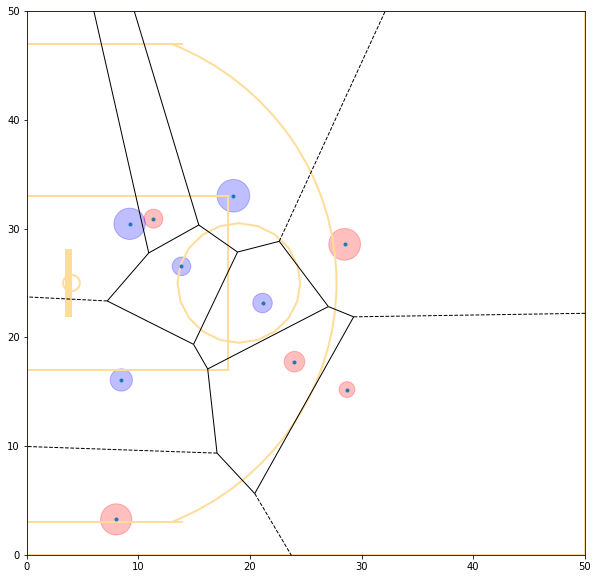

In [170]:
vor = Voronoi(points)
voronoi_plot_2d(vor, show_vertices=0)

size_circ = []
color_circ = []
team2color = {}
flag = False
for team in teams:
    team2color[team] = 'r' if not flag else 'b'
    flag = True

for i in range(10):
    player = players[i]
    val = frame_result[player]
    size_circ.append(val)
    color_circ.append(team2color[get_player_team(player, teams, frame_data)])
    
size_circ = [x*10 for x in size_circ]

draw_court(color='#ffdd99',outer_lines=True)
plt.xlim(0,50)
plt.ylim(0,50)

plt.scatter(points[:,0], points[:,1], s=size_circ, c=color_circ, alpha=0.25)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.gcf().set_size_inches(10, 10, forward=True)
plt.show()